In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)


from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import tflscripts
import json
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import tree
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import TruncatedSVD
import pickle

configuration = tflscripts.read_configuration()
df = pd.read_pickle('results_retrained_specificity.p')

In [2]:
def to_recall_bin(acc):
    bins = [
#         [0.0, 0.5],
        [0.0, 0.7],
        [0.7, 0.9],
#         [0.85, 0.95],
        [0.9, 1.0]
    ]
    return [i for i, b in enumerate(bins) if b[0] <= acc and b[1] >= acc][0]

def to_transfer_one_key(row):
    columns =  ['source_placement', 'target_placement', 'source_room', 'target_room', 'source_device', 'target_device']
    return '_'.join(row[columns])

df['transfer_one_key'] = [to_transfer_one_key(row) for i, row in df.iterrows()]
df['recall_bin'] = [to_recall_bin(a) for a in df['recall']]

In [3]:
df['specificity_combined'] = df.specificity_for_retrained.combine_first(df.specificity_4)

In [4]:
# df_to_transfer = df.loc[(df.first_predictions == 1) | (df.first_predictions == 0)]
df_to_transfer = df.loc[(df.first_predictions == 1)]
len(df_to_transfer)

18660

In [5]:
df_to_transfer.type_of_transfer.unique()

array(['Same device type in different place',
       'Different device in same place', 'Same device across spaces',
       'Same device type across spaces', 'Same device in different place',
       'Same device type in same place', 'No transfer',
       'Same device in same place'], dtype=object)

In [6]:
accuracies = {}

# filtered = df.loc[df.accuracy_negative >= 0.95]
filtered = df_to_transfer
filtered = filtered.loc[filtered.type_of_transfer != 'No transfer']
# filtered = filtered.loc[filtered.type_of_transfer != 'Across spaces']

x_columns = [
    'features',
    'classifier',
    'label',
    'samples',
    'type_of_transfer',
    'source_device_type',
    'target_device_type',
    'f1_wt',
    'specificity_combined',
    'num_activities_for_specificity'
]

def to_x_and_y(filtered, columns=x_columns):

    X = filtered[columns]

    y = filtered['recall_bin']

    X = [dict(r.iteritems()) for _, r in X.iterrows()]
    y = y.values

    return X, y

def predict_for_sample(sample_train, sample_test):
    X_train, y_train = to_x_and_y(sample_train)
    X_test, y_test = to_x_and_y(sample_test)

    ppl = Pipeline([
        ('vect', DictVectorizer()),
        ('impute', Imputer()),
        ('clf', RandomForestClassifier())
    ])

    ppl.fit(X_train, y_train)
    predicted = ppl.predict(X_test)
    accuracy = accuracy_score(y_test, predicted)
    print('Accuracy', accuracy)

    predictions = pd.Series(predicted)
    predictions.index = sample_test.index
    return predictions

# predicted = cross_val_predict(ppl, X, y,
#                               cv=StratifiedKFold(n_splits=5, shuffle=True))

# accuracy = accuracy_score(y, predicted)
# print(accuracy)

predictions = []

print('Placement')
placements = filtered.loc[(filtered.type_of_transfer == 'Same device in different place') | (filtered.type_of_transfer == 'Same device type in different place')]
placements_transfer_keys = placements.transfer_key.unique()
for transfer_key in placements_transfer_keys:
    sample_test = filtered.loc[filtered.transfer_key == transfer_key]
    sample_train = filtered.loc[~filtered.index.isin(sample_test.index)]

    predictions.append(predict_for_sample(sample_train, sample_test))

# sample_test = filtered.loc[(filtered.source_room == 'scott') & ((filtered.type_of_transfer == 'Same device in different place') | (filtered.type_of_transfer == 'Same device type in different place'))]
# sample_train = filtered.loc[~filtered.index.isin(sample_test.index)]

# predictions.append(predict_for_sample(sample_train, sample_test))

# sample_test = filtered.loc[(filtered.source_room == 'robotics') & ((filtered.type_of_transfer == 'Same device in different place') | (filtered.type_of_transfer == 'Same device type in different place'))]
# sample_train = filtered.loc[~filtered.index.isin(sample_test.index)]

# predictions.append(predict_for_sample(sample_train, sample_test))

print('Room')
sample_test = filtered.loc[(filtered.target_room == 'synergy') & ((filtered.type_of_transfer == 'Same device type across spaces') | (filtered.type_of_transfer == 'Same device across spaces'))]
sample_train = filtered.loc[~filtered.index.isin(sample_test.index)]

predictions.append(predict_for_sample(sample_train, sample_test))

sample_test = filtered.loc[(filtered.target_room == 'scott') & ((filtered.type_of_transfer == 'Same device type across spaces') | (filtered.type_of_transfer == 'Same device across spaces'))]
sample_train = filtered.loc[~filtered.index.isin(sample_test.index)]

predictions.append(predict_for_sample(sample_train, sample_test))

sample_test = filtered.loc[(filtered.target_room == 'robotics') & ((filtered.type_of_transfer == 'Same device type across spaces') | (filtered.type_of_transfer == 'Same device across spaces'))]
sample_train = filtered.loc[~filtered.index.isin(sample_test.index)]

predictions.append(predict_for_sample(sample_train, sample_test))


print('Replica')
replicas = filtered.loc[(filtered.type_of_transfer == 'Same device in same place') | (filtered.type_of_transfer == 'Same device type in same place')]
replicas_keys = replicas.transfer_one_key.unique()
for transfer_key in replicas_keys:
    sample_test = filtered.loc[filtered.transfer_one_key == transfer_key]
    sample_train = filtered.loc[~filtered.index.isin(sample_test.index)]

    predictions.append(predict_for_sample(sample_train, sample_test))

# print('Replica Sink')
# sample_test = filtered.loc[(filtered.source_placement == 'Sink') & ((filtered.type_of_transfer == 'Same device type in same place') | (filtered.type_of_transfer == 'Same device in same place'))]
# sample_train = filtered.loc[~filtered.index.isin(sample_test.index)]

# predictions.append(predict_for_sample(sample_train, sample_test))

# print('Replica Table')
# sample_test = filtered.loc[(filtered.source_placement == 'Table') & ((filtered.type_of_transfer == 'Same device type in same place') | (filtered.type_of_transfer == 'Same device in same place'))]
# sample_train = filtered.loc[~filtered.index.isin(sample_test.index)]

# predictions.append(predict_for_sample(sample_train, sample_test))

# print('Replica Coffee')
# sample_test = filtered.loc[(filtered.source_placement == 'Coffee') & ((filtered.type_of_transfer == 'Same device type in same place') | (filtered.type_of_transfer == 'Same device in same place'))]
# sample_train = filtered.loc[~filtered.index.isin(sample_test.index)]

# predictions.append(predict_for_sample(sample_train, sample_test))

print('Sensor board')
boards = filtered.loc[(filtered.type_of_transfer == 'Different device in same place')]
boards_transfer_keys = boards.transfer_key.unique()
for transfer_key in boards_transfer_keys:
    sample_test = filtered.loc[filtered.transfer_key == transfer_key]
    sample_train = filtered.loc[~filtered.index.isin(sample_test.index)]

    predictions.append(predict_for_sample(sample_train, sample_test))

df['predictions'] = pd.concat(predictions)

Placement
Accuracy 0.877777777778
Accuracy 0.936507936508
Accuracy 0.904761904762
Accuracy 0.861111111111
Accuracy 0.833333333333
Accuracy 0.855555555556
Accuracy 0.770833333333
Accuracy 0.746913580247
Accuracy 0.883333333333
Accuracy 0.722222222222
Accuracy 0.884259259259
Accuracy 0.766666666667
Accuracy 0.880758807588
Accuracy 0.822822822823
Accuracy 0.828798185941
Accuracy 0.844202898551
Accuracy 0.78216374269
Accuracy 0.924242424242
Room
Accuracy 0.814814814815
Accuracy 0.824133050248
Accuracy 0.847222222222
Replica
Accuracy 0.711111111111
Accuracy 0.930555555556
Accuracy 0.75
Accuracy 0.861111111111
Accuracy 0.888888888889
Accuracy 0.755555555556
Accuracy 0.8125
Accuracy 0.746031746032
Accuracy 0.882716049383
Accuracy 0.857142857143
Accuracy 0.825396825397
Sensor board
Accuracy 1.0
Accuracy 0.9
Accuracy 0.583333333333
Accuracy 1.0
Accuracy 1.0
Accuracy 1.0
Accuracy 0.8
Accuracy 1.0
Accuracy 0.866666666667
Accuracy 0.966666666667
Accuracy 0.6
Accuracy 0.977777777778
Accuracy 0.92
A

In [84]:
ppl.fit(X, y)

Pipeline(steps=[('vect', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True)), ('impute', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

In [11]:
# predictions = pd.Series(predicted)
# predictions.index = filtered.index
# df['predictions'] = predictions

df_tested = df.loc[df.predictions >= 0]
counts = df_tested[['recall_bin', 'predictions']].groupby(['recall_bin', 'predictions']).size()
counts = pd.DataFrame(counts)
counts.columns = ['count']
counts.pivot_table(index=['recall_bin'], columns=['predictions'], values=['count'])

count                
predictions    0.0  1.0  2.0   3.0
recall_bin                        
0            12021  453   73   305
1             1396  423   92   249
2              354  141   43   219
3              699  223  107  1610

In [7]:
df.to_pickle('results_with_accuracy_classified_sr_non_random-f1.p')

In [10]:
filtered_x, filtered_y = to_x_and_y(filtered, columns=[
    'features',
    'classifier',
    'label',
    'samples',
    'type_of_transfer',
    'source_device_type',
    'target_device_type',
    'f1_wt',
    'specificity'
])

filtered_x = DictVectorizer().fit_transform(filtered_x)
filtered_x = pd.DataFrame(filtered_x.toarray())

filtered_y_s = pd.Series(filtered_y, index=filtered_x.index)
filtered_x_s = filtered_x.sample(10000)
filtered_y_s = filtered_y_s[filtered_x_s.index]

ValueError: Cannot take a larger sample than population when 'replace=False'

In [ ]:
plt.rcParams["figure.figsize"] = (10, 5)

rf = ppl.named_steps['clf']
importances = pd.Series(rf.feature_importances_)
importances.index = ppl.named_steps['vect'].feature_names_
importances = importances.sort_values(ascending=False)
importances.plot.bar()

In [30]:
categories = {
    'f1_wt': [],
    'specificity': [],
    'samples': [],
    'features': [],
    'type_of_transfer': [],
    'device_type': [],
    'label': [],
    'classifier': []
}

for category in categories:
    for i in importances.index:
        if category in i:
            categories[category] += [importances[i]]
            
df_importances = pd.DataFrame()

for category in categories:
    df_importances = pd.concat([pd.DataFrame({category: pd.Series(categories[category])}), df_importances], axis=1)

df_importances = df_importances.rename(index=str, columns={
    'f1_wt': 'F1 score before transfer',
    'specificity': 'Specificity of target samples',
    'samples': 'Number of training samples',
    'features': 'Sensor channels used',
    'type_of_transfer': 'Type of transfer',
    'device_type': 'Types of sensor boards',
    'label': 'Activity',
    'classifier': 'Classifier'
})

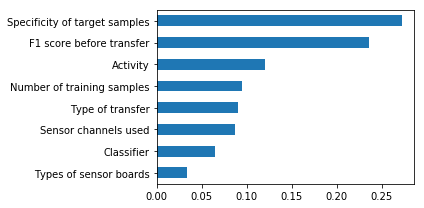

In [34]:
plt.rcParams["figure.figsize"] = (6, 3)
df_importances.sum().sort_values().plot.barh()
plt.tight_layout()

plt.savefig('../plots/metaclassifier_importances.pdf')
plt.show()